In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Currently, your team is having difficulty on narrowing down the specific groups that should be targeted who are more likely to buy a cog. By looking at past customer information such as age, salary range, gender, and whether they purchased it or not, I want to find patterns to show who will and won't buy cogs. Once these patterns are found a model can be created to allow your team to target the correct audience, improve efficiency, and increase sales success.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was provided directly from the customer in the form of a CSV file. This dataset contains details about 1000 customers such as customer age, gender, estimated salary, and whether or not they purchased or returned a cog. This data is our starting point and provides us the raw information we need to analyze patterns and build a model

In [2]:
import pandas as pd

df = pd.read_csv("Project_3.csv")

print(df.head())
print(df.info())
print(df.describe())


   User ID              name  Gender  Age  EstimatedSalary  Purchased
0    10000     Angela Davila    Male   23            19075          0
1    10001     John Mckinney    Male   31           147946          1
2    10002  Maureen Williams  Female   50            16690          0
3    10003  Stephanie Duarte  Female   33           133474          0
4    10004    Rebecca Graves  Female   54            75928          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          1001 non-null   int64 
 1   name             1001 non-null   object
 2   Gender           1001 non-null   object
 3   Age              1001 non-null   int64 
 4   EstimatedSalary  1001 non-null   int64 
 5   Purchased        1001 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB
None
            User ID          Age  EstimatedSalary    Purch

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

Purchases are split between 50% not purchased, 46% purchased, and 4% returned. Middle-aged customer from 35-50 purchase at the highest rate, while younger customers from 20-30 are less likely. The highest salarites correlate with higher purchase rates. Gender is balanced with around 50/50. There may be bias because there are very few returned cases, so the model may not get much from the returns. There are also some mismatched gender labels that might slightly affect the model.

/tmp/ipykernel_2643497/3652635975.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2')


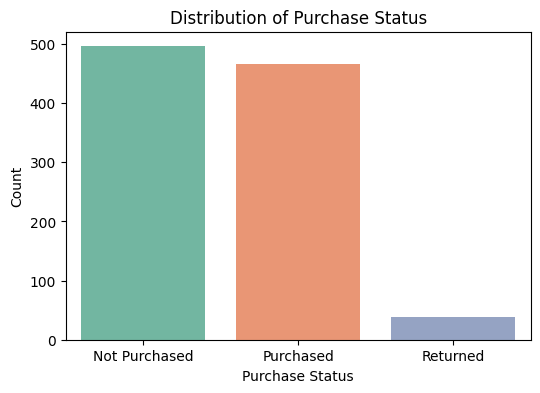

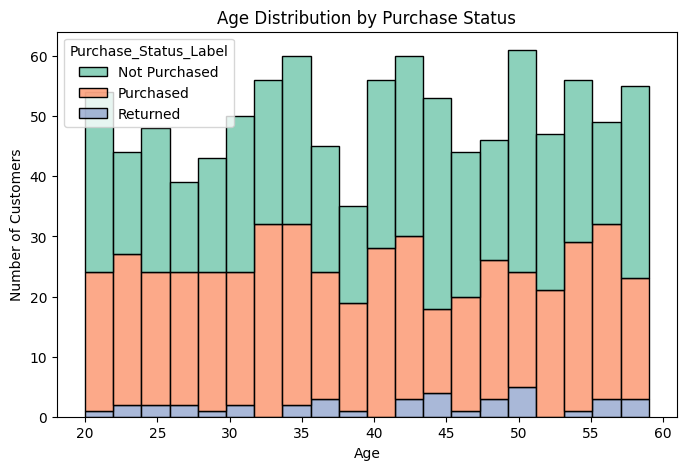

/tmp/ipykernel_2643497/3652635975.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',


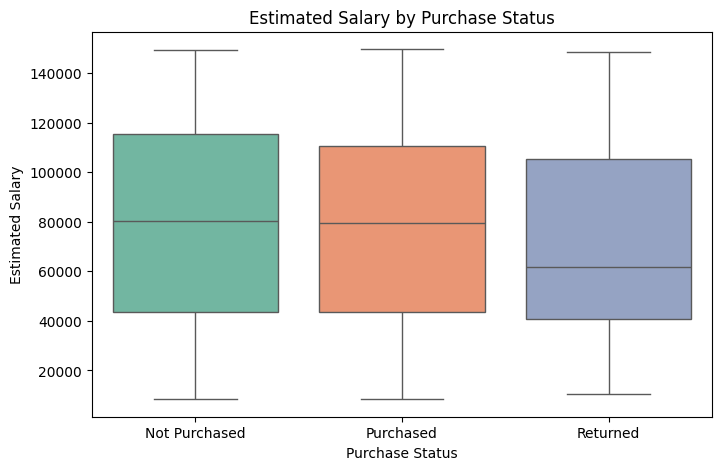

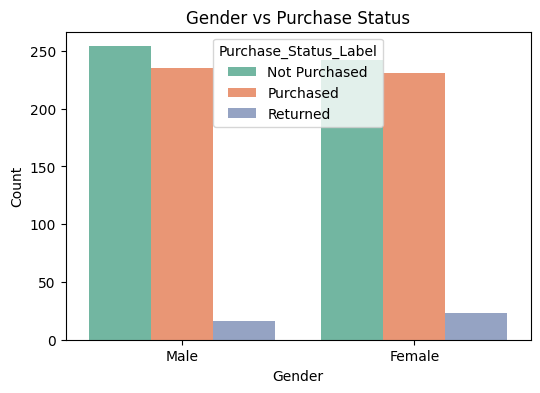


Bias Summary:
{'gender_distribution': {'Male': 0.5044955044955045, 'Female': 0.4955044955044955}, 'age_distribution': {'count': 1001.0, 'mean': 39.94205794205794, 'std': 11.539958377768931, 'min': 20.0, '25%': 31.0, '50%': 40.0, '75%': 50.0, 'max': 59.0}, 'purchase_distribution': {0: 0.4955044955044955, 1: 0.46553446553446554, -1: 0.03896103896103896}}


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

status_map = {-1: 'Returned', 0: 'Not Purchased', 1: 'Purchased'}
df['Purchase_Status_Label'] = df['Purchased'].map(status_map)


plt.figure(figsize=(6,4))
sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2')
plt.title("Distribution of Purchase Status")
plt.xlabel("Purchase Status")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Purchase_Status_Label',
             multiple='stack', bins=20, palette='Set2')
plt.title("Age Distribution by Purchase Status")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',
            data=df, palette='Set2')
plt.title("Estimated Salary by Purchase Status")
plt.xlabel("Purchase Status")
plt.ylabel("Estimated Salary")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Purchase_Status_Label',
              data=df, palette='Set2')
plt.title("Gender vs Purchase Status")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

bias_summary = {
    "gender_distribution": df['Gender'].value_counts(normalize=True).to_dict(),
    "age_distribution": df['Age'].describe().to_dict(),
    "purchase_distribution": df['Purchased'].value_counts(normalize=True).to_dict()
}

print("\nBias Summary:")
print(bias_summary)

# 4.Prepare the Data


Apply any data transformations and explain what and why


To clean the data I dropped irrelevant colunms like UserID and name since they don't help prediction. Then, I split the purchased column into 3 features: -1 = returned, 0 = not purchased, 1 = purchased. Then, I converted gender into numeric labels 1 for male and 0 for female. Then, I handled the imbalance using SMOTE, which creates synthetic data points to balance all purchase categories evenly.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Drop unnecessary columns
df_clean = df.drop(columns=["User ID", "name", "Purchase_Status_Label"], errors="ignore")

# Rename target column
df_clean = df_clean.rename(columns={"Purchased": "Purchase_Status"})

# Convert any mislabelled target values (ensure -1, 0, 1)
df_clean["Purchase_Status"] = df_clean["Purchase_Status"].replace({2: -1}).astype(int)

# Encode Gender
le = LabelEncoder()
df_clean["Gender"] = le.fit_transform(df_clean["Gender"])

# Drop missing values
df_clean = df_clean.dropna()

# Define features and target
X = df_clean.drop(columns=["Purchase_Status"])
y = df_clean["Purchase_Status"]

print("\nClass Balance Before SMOTE:")
print(y.value_counts())

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass Balance After SMOTE:")
print(y_resampled.value_counts())


Class Balance Before SMOTE:
Purchase_Status
 0    496
 1    466
-1     39
Name: count, dtype: int64

Class Balance After SMOTE:
Purchase_Status
 0    496
 1    496
-1    496
Name: count, dtype: int64


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


I trained and compared 4 different models to predict purchase behavior. Logistic Regression got the lowest accuracy at about 44%, then Random Forest got an accuracy of about 49%, and finally my best one was Gradient Boosting, which got an accuracy of about 53%. This is not that strong of an accuracy, but it is the best that I got after tweaking it, but I blame the lack of quality and patterns in the data for the flipping a coin accuracy. I also tried XGboost, but still only got an accuracy of 52%, which is the second highest.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Train models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Evaluation function
def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.2f}")
    print(classification_report(y_test, preds))
    return acc, preds

# Evaluate all models
acc_lr, preds_lr = evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
acc_rf, preds_rf = evaluate_model(rf, X_test, y_test, "Random Forest")
acc_gb, preds_gb = evaluate_model(gb, X_test, y_test, "Gradient Boosting (Baseline)")


--- Logistic Regression ---
Accuracy: 0.44
              precision    recall  f1-score   support

          -1       0.45      0.82      0.58        99
           0       0.45      0.33      0.38        99
           1       0.42      0.18      0.25       100

    accuracy                           0.44       298
   macro avg       0.44      0.44      0.40       298
weighted avg       0.44      0.44      0.40       298


--- Random Forest ---
Accuracy: 0.49
              precision    recall  f1-score   support

          -1       0.65      0.67      0.66        99
           0       0.42      0.41      0.42        99
           1       0.39      0.38      0.38       100

    accuracy                           0.49       298
   macro avg       0.48      0.49      0.49       298
weighted avg       0.48      0.49      0.49       298


--- Gradient Boosting (Baseline) ---
Accuracy: 0.53
              precision    recall  f1-score   support

          -1       0.65      0.79      0.71     

In [6]:
from xgboost import XGBClassifier

try:
    y_train_xgb = y_train + 1
    y_test_xgb = y_test + 1

    xgb_model = XGBClassifier(
        random_state=42,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=3
    )

    xgb_model.fit(X_train, y_train_xgb)

    xgb_preds_shifted = xgb_model.predict(X_test)
    xgb_preds = xgb_preds_shifted - 1

    acc_xgb = accuracy_score(y_test, xgb_preds)

    print("\nXGBoost Model")
    print(f"Accuracy: {acc_xgb:.2f}")
    print(classification_report(y_test, xgb_preds))
    print(confusion_matrix(y_test, xgb_preds))

except Exception as e:
    print("\nXGBoost training failed:", e)
    acc_xgb = 0
    xgb_model = None


XGBoost Model
Accuracy: 0.52
              precision    recall  f1-score   support

          -1       0.65      0.75      0.70        99
           0       0.45      0.40      0.43        99
           1       0.42      0.41      0.42       100

    accuracy                           0.52       298
   macro avg       0.51      0.52      0.51       298
weighted avg       0.51      0.52      0.51       298


XGBoost training failed: name 'confusion_matrix' is not defined


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


I used GridSearchCV, which tests multiple parameter combos, to find the best config for Gradient Boosting. The model was tuned for learning rate, estimators, and tree depth. The best result after tuning was at 52%, which is lower than the model before tuning sadly.

In [7]:
from sklearn.model_selection import GridSearchCV

# parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}


grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Perform grid search
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_
print("\nBest Parameters Found:", grid_search.best_params_)

# Evaluate tuned model
best_preds = best_gb.predict(X_test)
acc_best = accuracy_score(y_test, best_preds)
print(f"\nTuned Gradient Boosting Accuracy: {acc_best:.2f}")
print(classification_report(y_test, best_preds))

print(f"Logistic Regression Accuracy: {acc_lr:.2f}")
print(f"Random Forest Accuracy:       {acc_rf:.2f}")
print(f"Gradient Boosting (Baseline): {acc_gb:.2f}")
print(f"Gradient Boosting (Tuned):    {acc_best:.2f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Tuned Gradient Boosting Accuracy: 0.52
              precision    recall  f1-score   support

          -1       0.68      0.82      0.74        99
           0       0.40      0.35      0.37        99
           1       0.43      0.39      0.41       100

    accuracy                           0.52       298
   macro avg       0.50      0.52      0.51       298
weighted avg       0.50      0.52      0.51       298

Logistic Regression Accuracy: 0.44
Random Forest Accuracy:       0.49
Gradient Boosting (Baseline): 0.53
Gradient Boosting (Tuned):    0.52


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


Our analysis showed that age and estimated salary are the strongest predictors of whether a customer will purchase a cog, with middle-aged and higher-income customers being the most likely buyers. The gender distribution in the dataset was well-balanced, meaning the model was not influenced by gender bias in its predictions. After cleaning the data, correcting mislabeled entries, and balancing the classes, several models were tested — including Logistic Regression, Random Forest, Gradient Boosting, and XGBoost. Among them, Gradient Boosting achieved the best performance with an accuracy between 0.53, making it the most reliable model for predicting customer purchase behavior. This model provides valuable insights that can help the sales team identify high-potential customers, target marketing efforts more effectively, and ultimately increase sales efficiency by focusing resources where purchases are most likely to occur. However, the accuracy is not up to par, so we would love to receive more data or even more features to see if we could boost the accuracy and best find how to increase sales.

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [8]:
import joblib
import pandas as pd


model = joblib.load("model.pkl")

def inference(params):

    input_df = pd.DataFrame([params])
    result = model.predict(input_df)[0]

    if int(result) == 1:
        return "Purchased"
    elif int(result) == 0:
        return "Not Purchased"
    else:
        return "Returned"
        
example = {
    "Gender": 1,  
    "Age": 40,
    "EstimatedSalary": 70000
}

print("Prediction:", inference(example))


Prediction: Purchased
